In [12]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from shapely.geometry import Point
import matplotlib.pyplot as plt
from pyproj import Transformer

In [13]:
# Load OD matrix
df = pd.read_excel('../../data/europe/data_europe.xlsx')

# 2. Ulož název krajů ze sloupce a nastav index
df = df.rename(columns={'University ↓ / Student →': 'origin'})
df = df.set_index('origin')

# 3. Očisti názvy (pro jistotu, kvůli shodě)
df.index = df.index.str.strip()
df.columns = df.columns.str.strip()

# 4. Pro každou krajskou kombinaci: pokud je řádek == sloupec → nastav 0
for region in df.index:
    if region in df.columns:
        df.at[region, region] = 0

# 5. Výstup pro kontrolu
df

,Belgium,Bulgaria,Czechia,Denmark,Germany,Estonia,Ireland,Greece,Spain,France,...,Romania,Sweden,Iceland,Norway,Switzerland,United Kingdom,North Macedonia,Albania,Serbia,Türkiye
origin,,,,,,,,,,,,,,,,,,,,,
Belgium,0,166,62,36,747,31,74,411,924,19104,...,343,71,13,35,306,342,15,172,81,771
Bulgaria,28,0,12,20,1813,3,399,4019,96,111,...,38,237,2,105,25,2772,1060,241,596,868
Czechia,38,119,0,32,904,17,50,195,239,273,...,162,104,8,152,33,346,52,50,181,520
Denmark,230,378,507,0,3248,121,111,812,1506,606,...,1024,1521,820,2820,208,786,19,17,38,162
Germany,3089,5410,1512,770,0,365,990,4356,8252,9704,...,2993,755,135,655,6730,5670,644,2981,1289,16585
Estonia,13,6,3,7,89,0,12,16,46,43,...,10,15,3,6,6,60,3,5,10,136
Ireland,231,77,325,51,1087,17,0,170,828,1246,...,125,104,16,67,120,1477,3,12,19,199
Greece,95,280,15,8,1294,5,5,0,62,93,...,176,30,0,10,13,75,36,1564,87,132
Spain,640,440,122,94,2434,83,220,417,0,11861,...,1626,193,44,413,578,1141,32,94,121,333


In [14]:
# Příchozí studenti do každého kraje
prichozi = df.sum(axis=1).rename('prichozi')

prichozi.head()

origin
Belgium      32648
Bulgaria     14060
Czechia      27056
Denmark      22515
Germany     124346
Name: prichozi, dtype: int64

In [15]:
# Odchozí studenti z každého kraje
odchozi = df.sum(axis=0).rename('odchozi')

odchozi.head()

Belgium      15102
Bulgaria     20311
Czechia      10715
Denmark       4486
Germany     109673
Name: odchozi, dtype: int64

In [16]:
# Load spatial regions
gdf = gpd.read_file('../../data/europe/CNTR_RG_01M_2024_3035.gpkg')

# Keep only necessary columns and compute centroids
gdf = gdf[['NAME_ENGL', 'geometry']]

# Compute centroids
gdf['centroid'] = gdf.representative_point()

# Transformer from WGS84 to the layer's CRS
transformer = Transformer.from_crs("EPSG:4326", gdf.crs, always_xy=True)

# Define manual centroid for Türkiye (shifted slightly west from Ankara area)
x, y = transformer.transform(31.5, 39.0)  # longitude, latitude – adjust as needed
manual_centroids = {
    'Türkiye': Point(x, y)
}

# Apply manual centroid where specified
gdf['centroid'] = gdf.apply(
    lambda row: manual_centroids.get(row['NAME_ENGL'], row['centroid']),
    axis=1
)

# Show the result
gdf.head()

,NAME_ENGL,geometry,centroid
0,Ilemi Triangle,"MULTIPOLYGON (((7391633.521 -1433654.651, 7392...",POINT (7311013.661 -1454360.241)
1,Andorra,"POLYGON ((3627760.953 2188194.002, 3627277.391...",POINT (3630298.359 2198722.934)
2,United Arab Emirates,"MULTIPOLYGON (((8767105.237 1705081.232, 87679...",POINT (8761060.874 1449540.399)
3,Afghanistan,"POLYGON ((9034788.364 3786148.688, 9037836.72 ...",POINT (9072877.414 3153743.566)
4,Antigua and Barbuda,"MULTIPOLYGON (((-2523559.791 2859842.723, -252...",POINT (-2564641.643 2797231.693)


In [17]:
# Převod na DataFrame a zajištění správného indexu
df_prichozi = prichozi.reset_index().set_index('origin')
df_odchozi = odchozi.reset_index().set_index('index')
df_prichozi.head()

,prichozi
origin,
Belgium,32648
Bulgaria,14060
Czechia,27056
Denmark,22515
Germany,124346


In [18]:
# Nejdřív merge příchozích
gdf = gdf.merge(df_prichozi, left_on='NAME_ENGL', right_index=True, how='left')

# Potom merge odchozích
gdf = gdf.merge(df_odchozi, left_on='NAME_ENGL', right_index=True, how='left')

# Vyplníme případné NaNy nulou
gdf[['prichozi', 'odchozi']] = gdf[['prichozi', 'odchozi']].fillna(0).astype(int)
gdf

,NAME_ENGL,geometry,centroid,prichozi,odchozi
0,Ilemi Triangle,"MULTIPOLYGON (((7391633.521 -1433654.651, 7392...",POINT (7311013.661 -1454360.241),0,0
1,Andorra,"POLYGON ((3627760.953 2188194.002, 3627277.391...",POINT (3630298.359 2198722.934),0,0
2,United Arab Emirates,"MULTIPOLYGON (((8767105.237 1705081.232, 87679...",POINT (8761060.874 1449540.399),0,0
3,Afghanistan,"POLYGON ((9034788.364 3786148.688, 9037836.72 ...",POINT (9072877.414 3153743.566),0,0
4,Antigua and Barbuda,"MULTIPOLYGON (((-2523559.791 2859842.723, -252...",POINT (-2564641.643 2797231.693),0,0
...,...,...,...,...,...
255,South Africa,"MULTIPOLYGON (((7560594.198 -6091696.737, 7559...",POINT (6114843.858 -4827929.328),0,0
256,Zambia,"POLYGON ((6898225.503 -2887860.976, 6899661.19...",POINT (6421832.723 -3402653.519),0,0
257,Zimbabwe,"MULTIPOLYGON (((6864077.876 -3601044.279, 6866...",POINT (6867632.343 -3903335.74),0,0
258,South Korea,"MULTIPOLYGON (((10511611.774 8376538.587, 1051...",POINT (10083371.234 8566725.146),0,0


In [19]:
gdf['celkem'] = gdf['prichozi'] + gdf['odchozi']
gdf

,NAME_ENGL,geometry,centroid,prichozi,odchozi,celkem
0,Ilemi Triangle,"MULTIPOLYGON (((7391633.521 -1433654.651, 7392...",POINT (7311013.661 -1454360.241),0,0,0
1,Andorra,"POLYGON ((3627760.953 2188194.002, 3627277.391...",POINT (3630298.359 2198722.934),0,0,0
2,United Arab Emirates,"MULTIPOLYGON (((8767105.237 1705081.232, 87679...",POINT (8761060.874 1449540.399),0,0,0
3,Afghanistan,"POLYGON ((9034788.364 3786148.688, 9037836.72 ...",POINT (9072877.414 3153743.566),0,0,0
4,Antigua and Barbuda,"MULTIPOLYGON (((-2523559.791 2859842.723, -252...",POINT (-2564641.643 2797231.693),0,0,0
...,...,...,...,...,...,...
255,South Africa,"MULTIPOLYGON (((7560594.198 -6091696.737, 7559...",POINT (6114843.858 -4827929.328),0,0,0
256,Zambia,"POLYGON ((6898225.503 -2887860.976, 6899661.19...",POINT (6421832.723 -3402653.519),0,0,0
257,Zimbabwe,"MULTIPOLYGON (((6864077.876 -3601044.279, 6866...",POINT (6867632.343 -3903335.74),0,0,0
258,South Korea,"MULTIPOLYGON (((10511611.774 8376538.587, 1051...",POINT (10083371.234 8566725.146),0,0,0


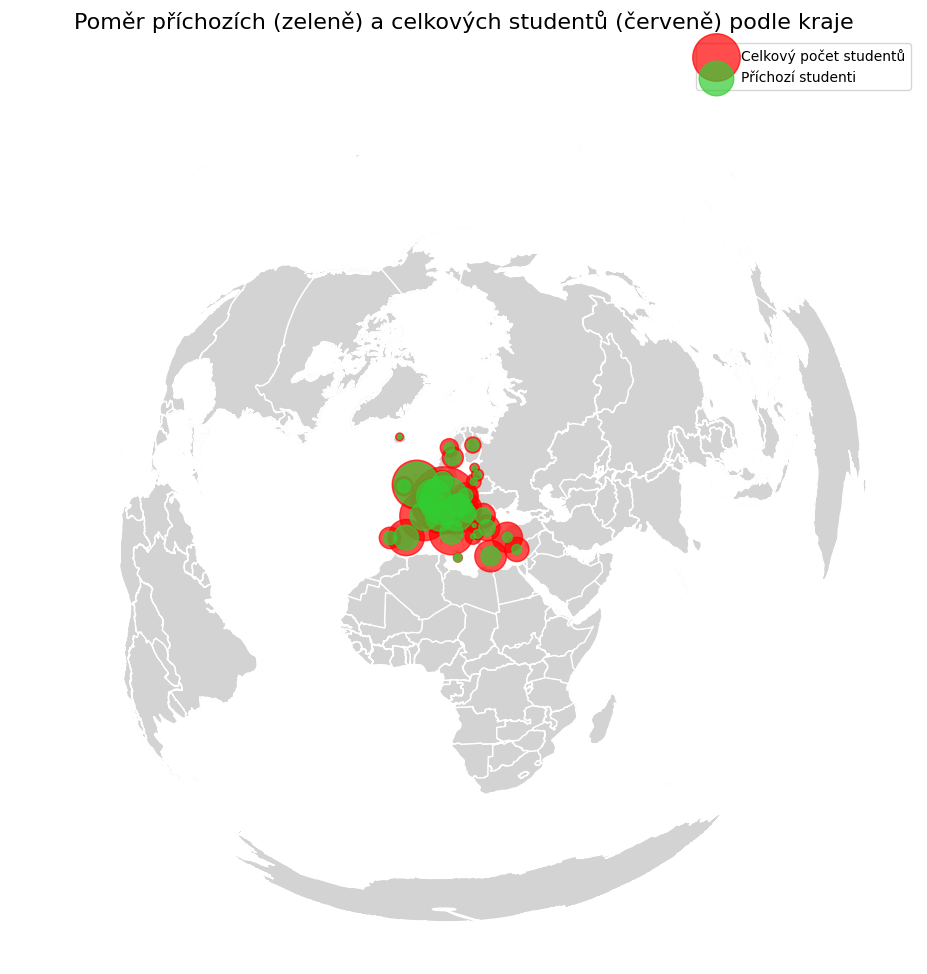

,NAME_ENGL,geometry,centroid,prichozi,odchozi,celkem
0,Ilemi Triangle,"MULTIPOLYGON (((7391633.521 -1433654.651, 7392...",POINT (7311013.661 -1454360.241),0,0,0
1,Andorra,"POLYGON ((3627760.953 2188194.002, 3627277.391...",POINT (3630298.359 2198722.934),0,0,0
2,United Arab Emirates,"MULTIPOLYGON (((8767105.237 1705081.232, 87679...",POINT (8761060.874 1449540.399),0,0,0
3,Afghanistan,"POLYGON ((9034788.364 3786148.688, 9037836.72 ...",POINT (9072877.414 3153743.566),0,0,0
4,Antigua and Barbuda,"MULTIPOLYGON (((-2523559.791 2859842.723, -252...",POINT (-2564641.643 2797231.693),0,0,0
...,...,...,...,...,...,...
255,South Africa,"MULTIPOLYGON (((7560594.198 -6091696.737, 7559...",POINT (6114843.858 -4827929.328),0,0,0
256,Zambia,"POLYGON ((6898225.503 -2887860.976, 6899661.19...",POINT (6421832.723 -3402653.519),0,0,0
257,Zimbabwe,"MULTIPOLYGON (((6864077.876 -3601044.279, 6866...",POINT (6867632.343 -3903335.74),0,0,0
258,South Korea,"MULTIPOLYGON (((10511611.774 8376538.587, 1051...",POINT (10083371.234 8566725.146),0,0,0


In [20]:
# 1. Nastavení figury a os
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# 2. Vykreslení krajských polygonů
gdf.plot(ax=ax, color='lightgrey', edgecolor='white')

# 3. Vykreslení centroidů pro celkový počet studentů (červeně)
gdf.set_geometry('centroid').plot(
    ax=ax,
    markersize=gdf['celkem'] / 100,  # Škálování podle celkového počtu studentů
    color='red',                    # Barva bodů (centroidů)
    alpha=0.7,                      # Průhlednost
    label='Celkový počet studentů'
)

# 4. Vykreslení centroidů pro příchozí studenty (zeleně)
gdf.set_geometry('centroid').plot(
    ax=ax,
    markersize=gdf['prichozi'] / 100,  # Škálování podle počtu příchozích studentů
    color='limegreen',                 # Barva bodů pro příchozí
    alpha=0.7,                         # Průhlednost
    label='Příchozí studenti'
)

# 5. Titulek, legenda a vzhled
ax.set_title("Poměr příchozích (zeleně) a celkových studentů (červeně) podle kraje", fontsize=16)
ax.axis('off')
ax.legend()
plt.tight_layout()
plt.show()
gdf

In [21]:
# Přiřaď sloupec centroid jako novou geometrii (už máš)
gdf['geometry'] = gdf['centroid']

# Odstraň původní sloupec 'centroid'
gdf = gdf.drop(columns='centroid')

# Nastav správný souřadnicový systém – EPSG:3035 (ETRS89 / LAEA Europe)
gdf = gdf.set_crs(epsg=3035)

# Ulož do GeoPackage
gdf.to_file('../../data/europe/europe_centriods.gpkg', driver='GPKG', layer='centroid_data')

print("✅ GeoPackage successfully exported as 'centroid_based_data_3035.gpkg' in EPSG:3035.")


✅ GeoPackage successfully exported as 'centroid_based_data_3035.gpkg' in EPSG:3035.
